# **Model Training**

### **Extra tools**

In [1]:
import winsound
from plyer import notification

def notify_user(header,message):
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    notification.notify(
        title= header,
        message= message,
        timeout=10
    )

### **Libraries Used**

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### **Load dataset**

In [3]:
df_pivot = pd.read_csv("pivot_dataset.csv", low_memory=False)

## **Pre-trainig**

**Map quality strings to numeric**

In [4]:
quality_map = {
    "Good": 1.0,
    "Estimated": 0.75,
    "Suspect": 0.5,
    "Contamination": 0.0
}

quality_columns = ['Dissolved Gas', 'EC', 'Optical', 'Oxidized Nitrogen', 
                   'Phosphorus', 'Salinity', 'Temperature', 'pH']

for col in quality_columns:
    if col in df_pivot.columns:
        df_pivot[col] = df_pivot[col].map(quality_map)

**Handle missing values**

In [5]:
numeric_cols = df_pivot.select_dtypes(include=['float64','int64']).columns
df_pivot[numeric_cols] = df_pivot[numeric_cols].fillna(df_pivot[numeric_cols].mean())
df_pivot = df_pivot.fillna(0)

**Encode target variable**

In [6]:
df_pivot['Target'] = df_pivot['Target'].map({'fair':0, 'good':1})

**Convert Sample.Date to datetime and extract features**

In [7]:
df_pivot['Sample.Date'] = pd.to_datetime(df_pivot['Sample.Date'], errors='coerce')
df_pivot['Year'] = df_pivot['Sample.Date'].dt.year
df_pivot['Month'] = df_pivot['Sample.Date'].dt.month

**Drop unnecessary columns**

In [8]:
df_pivot.drop(['GEMS.Station.Number', 'Sample.Date', 'Sample.Time', 'Final_Quality'], 
              axis=1, inplace=True, errors='ignore')

**Final dataset ready for ML**

In [9]:
print(df_pivot.head())
print("Shape:", df_pivot.shape)

   Depth  Dissolved Gas   EC  Optical  Oxidized Nitrogen  Phosphorus  \
0   0.25            1.0  1.0      0.5                1.0    0.810589   
1   0.20            0.5  1.0      0.0                1.0    0.000000   
2   0.20            1.0  1.0      0.0                1.0    0.810589   
3   0.18            1.0  1.0      0.0                1.0    1.000000   
4   0.27            1.0  1.0      0.0                1.0    1.000000   

   Salinity  Temperature        pH  Target  Year  Month  
0  0.783831          1.0  1.000000       0  2018      8  
1  0.783831          1.0  1.000000       0  2018     11  
2  0.783831          1.0  1.000000       0  2019      2  
3  0.783831          1.0  1.000000       0  2019      5  
4  0.783831          1.0  0.954819       0  2019      8  
Shape: (789370, 12)


## **Random Forest**

Confusion Matrix:
[[71033     4]
 [    0 86837]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71037
           1       1.00      1.00      1.00     86837

    accuracy                           1.00    157874
   macro avg       1.00      1.00      1.00    157874
weighted avg       1.00      1.00      1.00    157874

Balanced Accuracy: 0.999972

Cross-Validation Scores: [0.99997466 1.         1.         1.         0.99998733]
Mean CV Accuracy: 0.999992


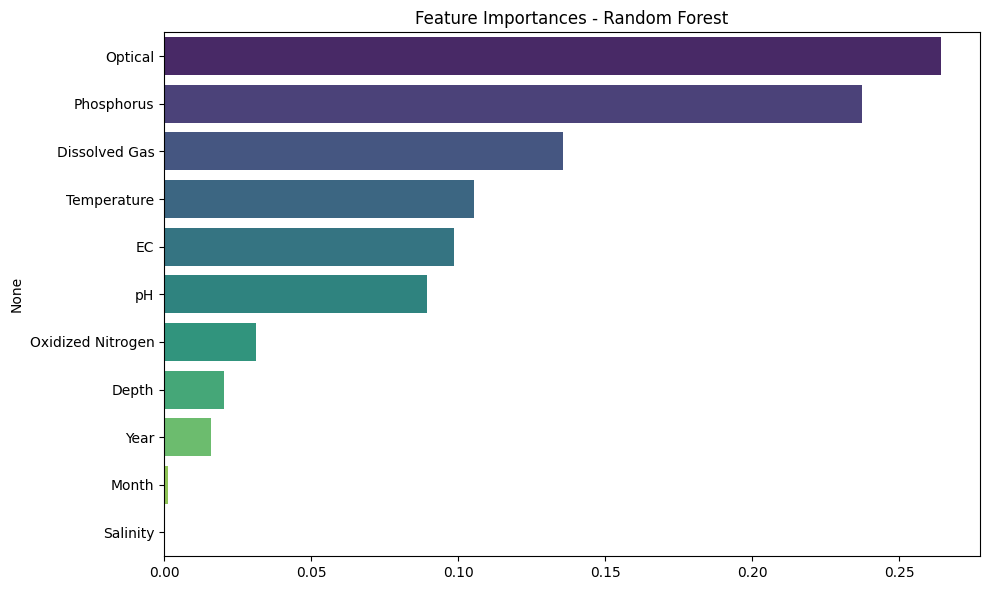

In [12]:
df = df_pivot.copy()

X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.6f}")

cv_scores = cross_val_score(rf, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.6f}")

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances.values, 
    y=importances.index, 
    hue=importances.index, 
    palette="viridis", 
    legend=False
)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

notify_user("Training Complete", "The Random Forest model has finished training and evaluation.")